In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical NVDA data clearly defined
nvda = yf.download("NVDA", start="2015-01-01", end="2025-04-01")

# Clearly define Price series
nvda["Price"] = nvda["Adj Close"] if 'Adj Close' in nvda.columns else nvda["Close"]

# Drop NaNs explicitly
nvda = nvda[["Price"]].dropna()

# Ensure business-day frequency explicitly
nvda = nvda.asfreq('B', method='ffill')

# Calculate daily returns
nvda["Returns"] = nvda["Price"].pct_change()

# Compute rolling standard deviations
nvda["Short_Term_Std"] = nvda["Price"].rolling(window=21).std()
nvda["Mid_Term_Std"]   = nvda["Price"].rolling(window=63).std()
nvda["Long_Term_Std"]  = nvda["Price"].rolling(window=252).std()

# Define standard deviation price bands clearly
nvda["Short_Upper"] = nvda["Price"] + nvda["Short_Term_Std"]
nvda["Short_Lower"] = nvda["Price"] - nvda["Short_Term_Std"]

nvda["Mid_Upper"]   = nvda["Price"] + (nvda["Mid_Term_Std"] * 1.5)
nvda["Mid_Lower"]   = nvda["Price"] - (nvda["Mid_Term_Std"] * 1.5)

nvda["Long_Upper"] = nvda["Price"] + (nvda["Long_Term_Std"] * 2)
nvda["Long_Lower"] = nvda["Price"] - (nvda["Long_Term_Std"] * 2)

# Display last rows for verification
print(nvda.tail())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Price   Returns Short_Term_Std Mid_Term_Std Long_Term_Std  \
Ticker                                                                       
Date                                                                         
2025-03-11  108.750000  0.016639      11.374275     9.858957     18.475462   
2025-03-12  115.739998  0.064276      11.485784    10.051121     18.404985   
2025-03-13  115.580002 -0.001382      11.595523    10.242553     18.319500   
2025-03-14  121.669998  0.052691      11.347315    10.309532     18.214475   
2025-03-17  119.529999 -0.017589      10.853484    10.405333     18.109099   

Price      Short_Upper Short_Lower   Mid_Upper   Mid_Lower  Long_Upper  \
Ticker                                                                   
Date                                                                     
2025-03-11  120.124275   97.375725  123.538436   93.961564  145.700925   
2025-03-12  127.225782  104.254214  130.816680  100.663316  152.549967   
2025-

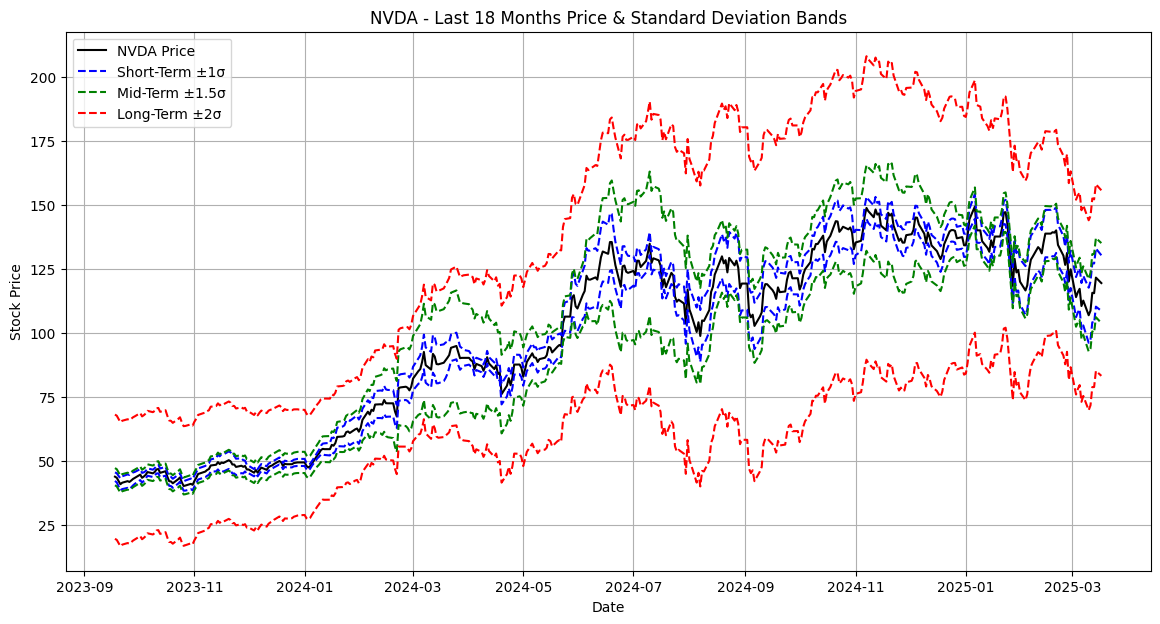

In [2]:
# Set start date clearly for the last 18 months
start_date_18m = nvda.index[-1] - pd.DateOffset(months=18)

# Subset explicitly by date
nvda_18m = nvda[nvda.index >= start_date_18m]

# Plot clearly (Price + Std Bands)
plt.figure(figsize=(14, 7))

plt.plot(nvda_18m.index, nvda_18m["Price"], label="NVDA Price", color="black")
plt.plot(nvda_18m.index, nvda_18m["Short_Upper"], linestyle="--", color="blue", label="Short-Term ±1σ")
plt.plot(nvda_18m.index, nvda_18m["Short_Lower"], linestyle="--", color="blue")
plt.plot(nvda_18m.index, nvda_18m["Mid_Upper"], linestyle="--", label="Mid-Term ±1.5σ", color="green")
plt.plot(nvda_18m.index, nvda_18m["Mid_Lower"], linestyle="--", color="green")
plt.plot(nvda_18m.index, nvda_18m["Long_Upper"], linestyle="--", label="Long-Term ±2σ", color="red")
plt.plot(nvda_18m.index, nvda_18m["Long_Lower"], linestyle="--", color="red")

plt.title("NVDA - Last 18 Months Price & Standard Deviation Bands")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


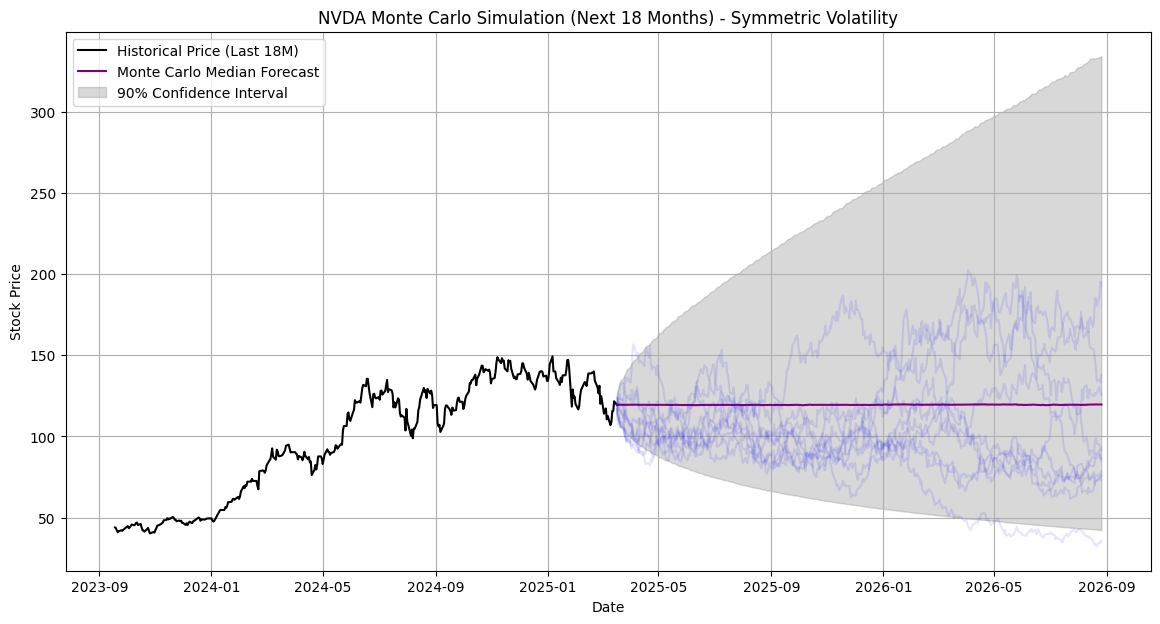


Monte Carlo Forecast Statistics:
Final Median Price: 119.68
95% Confidence Interval: (42.36, 334.31)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monte Carlo parameters
num_simulations = 100000   # Number of simulations
forecast_days = 18 * 21  # 18 months (~378 trading days)
last_price = nvda_18m["Price"].iloc[-1]  # Start from the last known price

# Extract historical log returns (log-normal assumption)
historical_returns = np.log(nvda_18m["Price"] / nvda_18m["Price"].shift(1)).dropna()

# Calculate mean and standard deviation of **log returns**
mu = historical_returns.mean()
sigma = historical_returns.std()

# Initialize matrix to hold simulated price paths
simulated_prices = np.zeros((forecast_days, num_simulations))

# Run Monte Carlo simulations using log returns
for sim in range(num_simulations):
    # Generate random normal daily log returns
    random_returns = np.random.normal(loc=0, scale=sigma, size=forecast_days)
    
    # Initialize price path with log returns
    price_path = [np.log(last_price)]  # Start with log price
    
    for r in random_returns:
        new_price_log = price_path[-1] + r  # Apply log returns
        price_path.append(new_price_log)
    
    # Convert log prices back to normal prices
    simulated_prices[:, sim] = np.exp(price_path[1:])

# Create a DataFrame for easy manipulation
simulation_df = pd.DataFrame(simulated_prices, index=pd.date_range(start=nvda_18m.index[-1], periods=forecast_days, freq='B'))

# Calculate key statistics from simulations
median_forecast = simulation_df.median(axis=1)  # Median scenario
upper_95 = simulation_df.quantile(0.95, axis=1)  # 95% confidence upper bound
lower_05 = simulation_df.quantile(0.05, axis=1)  # 5% confidence lower bound

# ---------------------------------------------
# Plot Monte Carlo Simulation Results
# ---------------------------------------------
plt.figure(figsize=(14,7))

# Plot historical prices (last 18 months)
plt.plot(nvda_18m.index, nvda_18m["Price"], color='black', label="Historical Price (Last 18M)")

# Plot the median forecast and confidence bands
plt.plot(simulation_df.index, median_forecast, color='purple', label="Monte Carlo Median Forecast")
plt.fill_between(simulation_df.index, lower_05, upper_95, color='gray', alpha=0.3, label="90% Confidence Interval")

# Overlay a few random simulations for illustration
for i in range(10):
    plt.plot(simulation_df.index, simulation_df.iloc[:, i], alpha=0.1, color="blue")

plt.title("NVDA Monte Carlo Simulation (Next 18 Months) - Symmetric Volatility")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Display forecast statistics
print("\nMonte Carlo Forecast Statistics:")
print(f"Final Median Price: {median_forecast.iloc[-1]:.2f}")
print(f"95% Confidence Interval: ({lower_05.iloc[-1]:.2f}, {upper_95.iloc[-1]:.2f})")


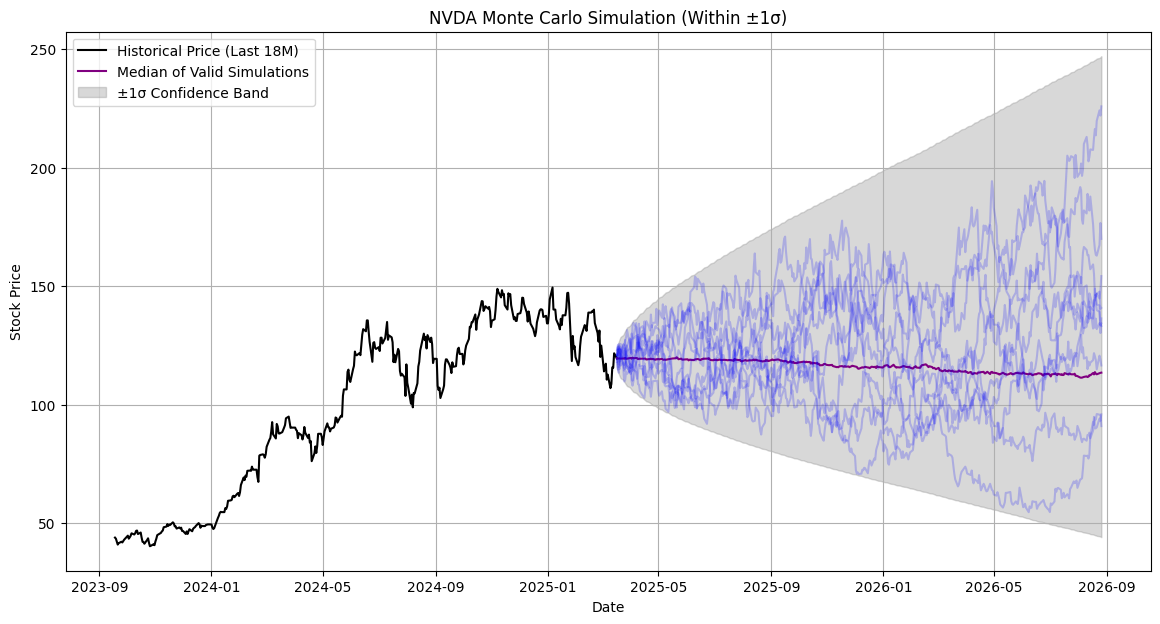


Filtered Monte Carlo Simulations Stats:
Total Simulations: 100000
Valid Simulations Within ±1σ: 1890
Percentage of Valid Paths: 1.89%
Final Median Price (Filtered): 113.51
±1σ Confidence Interval: (44.13, 246.95)


In [4]:
# ---------------------------------------------
# 1) Compute Mean & 2-Standard Deviation Bounds
# ---------------------------------------------
sim_mean = simulation_df.mean(axis=1)  # Mean forecasted price at each timestep
sim_std  = simulation_df.std(axis=1)   # Standard deviation of simulations

upper_bound = sim_mean + (1 * sim_std)  # +2σ boundary
lower_bound = sim_mean - (1 * sim_std)  # -2σ boundary

# ---------------------------------------------
# 2) Filter Simulations That Stay Within ±2σ
# ---------------------------------------------
valid_simulations = simulation_df.apply(lambda col: (col >= lower_bound) & (col <= upper_bound))
filtered_simulations = simulation_df.loc[:, valid_simulations.all(axis=0)]  # Keep only valid paths

# ---------------------------------------------
# 3) Plot Filtered Simulations Within 2σ
# ---------------------------------------------
plt.figure(figsize=(14,7))

# Plot historical price
plt.plot(nvda_18m.index, nvda_18m["Price"], color='black', label="Historical Price (Last 18M)")

# Plot filtered median forecast & confidence bands
filtered_median = filtered_simulations.median(axis=1)
plt.plot(filtered_simulations.index, filtered_median, color='purple', label="Median of Valid Simulations")

plt.fill_between(simulation_df.index, lower_bound, upper_bound, color='gray', alpha=0.3, label="±1σ Confidence Band")

# Overlay a few random valid simulations
for i in range(min(10, filtered_simulations.shape[1])):  
    plt.plot(filtered_simulations.index, filtered_simulations.iloc[:, i], alpha=0.2, color="blue")

plt.title("NVDA Monte Carlo Simulation (Within ±1σ)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------
# 4) Display Key Stats for Filtered Simulations
# ---------------------------------------------
print("\nFiltered Monte Carlo Simulations Stats:")
print(f"Total Simulations: {num_simulations}")
print(f"Valid Simulations Within ±1σ: {filtered_simulations.shape[1]}")
print(f"Percentage of Valid Paths: {filtered_simulations.shape[1] / num_simulations * 100:.2f}%")
print(f"Final Median Price (Filtered): {filtered_median.iloc[-1]:.2f}")
print(f"±1σ Confidence Interval: ({lower_bound.iloc[-1]:.2f}, {upper_bound.iloc[-1]:.2f})")


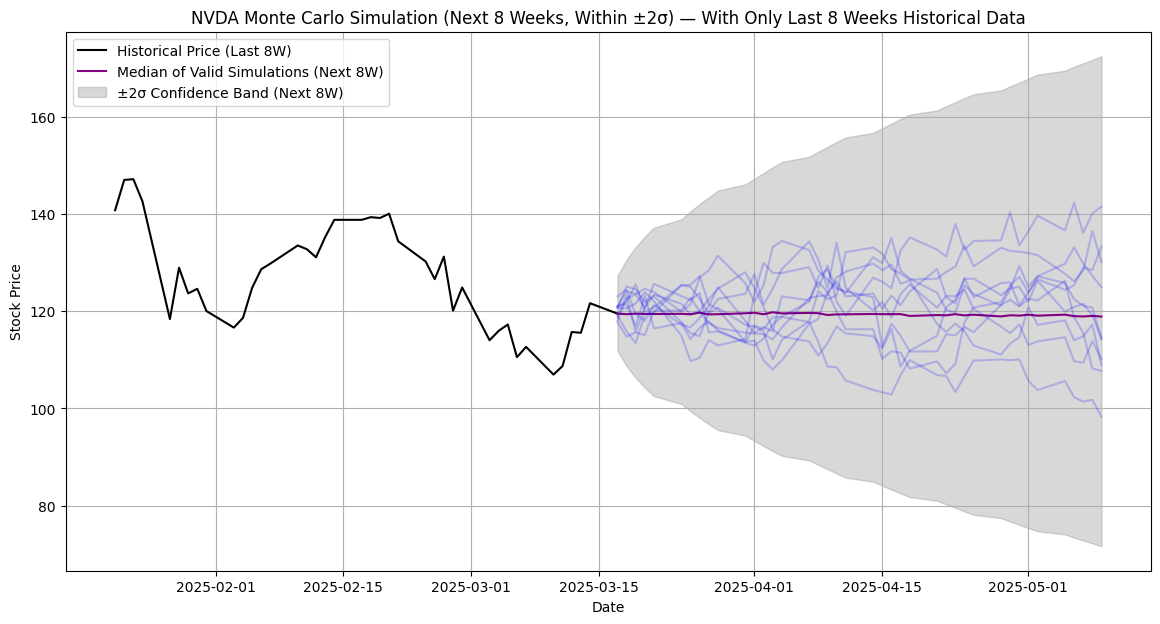


Monte Carlo Simulations (Next 8 Weeks) Stats:
Total Simulations: 100000
Valid Simulations Within ±2σ: 1890
Percentage of Valid Paths (Next 8W): 1.89%
Final Median Price (Next 8W): 118.92
±2σ Confidence Interval (Next 8W): (71.63, 172.53)


In [5]:
# ---------------------------------------------
# 1) Define Last & Next 8 Weeks (40 Trading Days Each)
# ---------------------------------------------
hist_days_8w = 40  # Last 8 weeks of historical data
forecast_days_8w = 40  # Next 8 weeks of Monte Carlo

# Subset only the last 8 weeks from historical NVDA data
nvda_last_8w = nvda_18m.iloc[-hist_days_8w:]  # Most recent 40 trading days

# Subset only the next 8 weeks from all Monte Carlo simulations
simulation_df_8w = simulation_df.iloc[:forecast_days_8w]  # First 40 rows
filtered_simulations_8w = filtered_simulations.iloc[:forecast_days_8w]  # Filtered set

# Compute new ±2σ confidence band for this window
sim_mean_8w = simulation_df_8w.mean(axis=1)
sim_std_8w  = simulation_df_8w.std(axis=1)

upper_bound_8w = sim_mean_8w + (2 * sim_std_8w)  # +2σ boundary
lower_bound_8w = sim_mean_8w - (2 * sim_std_8w)  # -2σ boundary

# ---------------------------------------------
# 2) Plot Last 8 Weeks Historical + Next 8 Weeks Forecast
# ---------------------------------------------
plt.figure(figsize=(14,7))

# Plot **only last 8 weeks** of historical prices
plt.plot(nvda_last_8w.index, nvda_last_8w["Price"], color='black', label="Historical Price (Last 8W)")

# Plot filtered median forecast for next 8 weeks
filtered_median_8w = filtered_simulations_8w.median(axis=1)
plt.plot(filtered_simulations_8w.index, filtered_median_8w, color='purple', label="Median of Valid Simulations (Next 8W)")

# Confidence band for next 8 weeks
plt.fill_between(filtered_simulations_8w.index, lower_bound_8w, upper_bound_8w, color='gray', alpha=0.3, label="±2σ Confidence Band (Next 8W)")

# Overlay a few random valid simulations for next 8 weeks
for i in range(min(10, filtered_simulations_8w.shape[1])):  
    plt.plot(filtered_simulations_8w.index, filtered_simulations_8w.iloc[:, i], alpha=0.2, color="blue")

plt.title("NVDA Monte Carlo Simulation (Next 8 Weeks, Within ±2σ) — With Only Last 8 Weeks Historical Data")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------
# 3) Display Key Stats for Next 8 Weeks
# ---------------------------------------------
print("\nMonte Carlo Simulations (Next 8 Weeks) Stats:")
print(f"Total Simulations: {num_simulations}")
print(f"Valid Simulations Within ±2σ: {filtered_simulations_8w.shape[1]}")
print(f"Percentage of Valid Paths (Next 8W): {filtered_simulations_8w.shape[1] / num_simulations * 100:.2f}%")
print(f"Final Median Price (Next 8W): {filtered_median_8w.iloc[-1]:.2f}")
print(f"±2σ Confidence Interval (Next 8W): ({lower_bound_8w.iloc[-1]:.2f}, {upper_bound_8w.iloc[-1]:.2f})")
